In [ ]:
%pip install pandas numpy pennylane

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import  pandas as pd
import seaborn as sns

In [14]:
dataset = pd.read_csv("soil_fertility.csv")
dataset.shape

(880, 13)

In [ ]:
dataset.head()

In [ ]:
# Low Fertility - 0
# Medium Fertility  - 1
# High Fertility - 2
dataset['Output'].value_counts()

<Axes: >

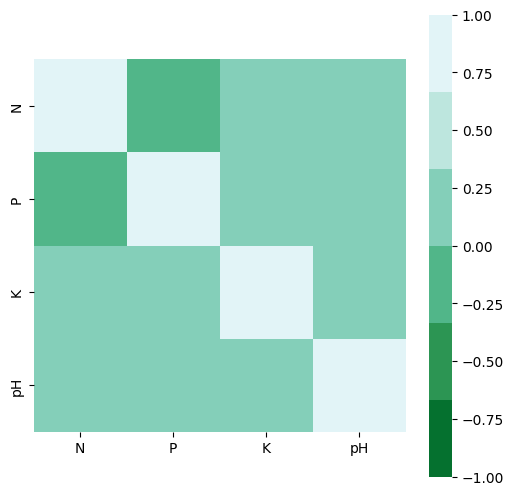

In [ ]:
labels = dataset[['Output']]
dataset = dataset.drop(['Output','EC','OC','S','Zn','Fe','Cu','Mn','B'], axis=1)
corr = dataset.corr()
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corr,
    cmap=sns.color_palette("BuGn_r"),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

In [19]:

features = dataset
features.head()

,N,P,K,pH
0,138,8.6,560,7.46
1,213,7.5,338,7.62
2,163,9.6,718,7.59
3,157,6.8,475,7.64
4,270,9.9,444,7.63


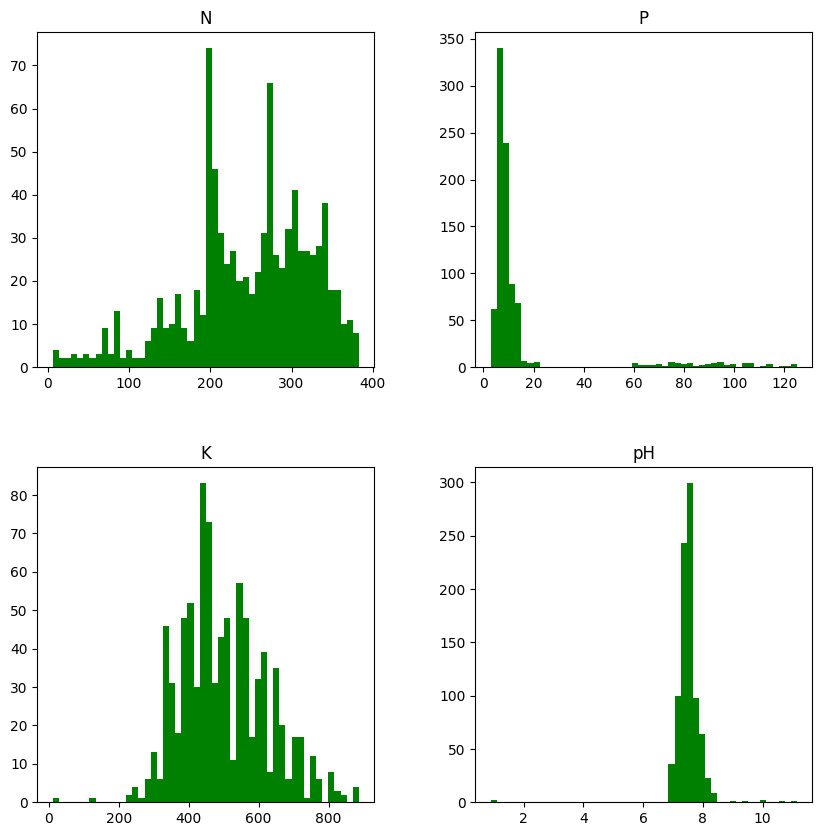

In [20]:
features.hist(bins=50, figsize=(10, 10), color ='green', grid=False)
plt.show()

In [47]:
from sklearn.model_selection import train_test_split

trainInput, validationInput, trainTarget, validationTarget = train_test_split(features, labels, test_size = 0.1, shuffle=True, random_state = 42)
print("Train Data Shape: ", trainInput.shape)

Train Data Shape:  (792, 4)


In [ ]:
# trainTarget = trainTarget.values.ravel()


In [49]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

svcClf = SVC()
svcClf.fit(trainInput, trainTarget)
model = svcClf

c:\Users\Cindi-Ann\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [50]:
pred = model.predict((validationInput))
model_acc = accuracy_score(validationTarget, pred)
print(type(model).__name__, " accuarcy is ", model_acc)


SVC  accuarcy is  0.9090909090909091


# Quantum Classifier

In [64]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.svm import SVC


scaler = StandardScaler().fit(features)
X_scaled = scaler.transform(features)

# scaling the labels to -1, 1 is important for the SVM and the
# definition of a hinge loss
y_scaled = 2 * (labels - 0.5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.1, shuffle=True, random_state = 42)

n_qubits = len(X_train[0])





dev_kernel = qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2 ** n_qubits, 2 ** n_qubits))
projector[0, 0] = 1

@qml.qnode(dev_kernel)
def kernel(x1, x2):
    """The quantum kernel."""
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

svm = SVC(kernel=kernel_matrix).fit(X_train, y_train)

with dev_kernel.tracker:
    predictions = svm.predict(X_test)
    accuracy_score(y_test,predictions,)

dev_kernel.tracker.totals['executions']


c:\Users\Cindi-Ann\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:737: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


KeyboardInterrupt: 